In [43]:
"""
Creates a Pytorch dataset to load the Pascal VOC & MS COCO datasets
"""

import config
import numpy as np
import os
import pandas as pd
import torch
import random 
import math 
import cv2
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import (
    cells_to_bboxes,
    iou_width_height as iou,
    non_max_suppression as nms,
)

from utils import xywhn2xyxy, xyxy2xywhn

ImageFile.LOAD_TRUNCATED_IMAGES = True

class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.mosaic_border = [image_size // 2, image_size // 2]
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)
    
    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4 = []
        s = self.image_size
        yc, xc = (int(random.uniform(x, 2 * s - x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(range(len(self)), k=3)  # 3 additional image indices
        random.shuffle(indices)
        print("XC YC", xc, yc)
        for i, index in enumerate(indices):
            # Load image
            label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
            bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
            img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
            img = np.array(Image.open(img_path).convert("RGB"))
            

            h, w = img.shape[0], img.shape[1]
            labels = np.array(bboxes)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            if labels.size:
                labels[:, :-1] = xywhn2xyxy(labels[:, :-1], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            labels4.append(labels)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, :-1],):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate
        labels4[:, :-1] = xyxy2xywhn(labels4[:, :-1], 2 * s, 2 * s)
        labels4[:, :-1] = np.clip(labels4[:, :-1], 0, 1)
        labels4 = labels4[labels4[:, 2] > 0]
        labels4 = labels4[labels4[:, 3] > 0]
        return img4, labels4 

    def __getitem__(self, index):

        image, bboxes = self.load_mosaic(index)
        

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        return image, bboxes

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)


In [44]:
import config 

IMAGE_SIZE = config.IMAGE_SIZE
train_dataset = YOLODataset(
    config.DATASET + "/train.csv",
    transform=config.train_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    img_dir=config.IMG_DIR,
    label_dir=config.LABEL_DIR,
    anchors=config.ANCHORS,
)


In [45]:
image, bboxes = train_dataset[2]

XC YC 411 251


In [46]:
image.shape

torch.Size([3, 416, 416])

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = config.COCO_LABELS if config.DATASET=='COCO' else config.PASCAL_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    for box in boxes:
        assert len(box) == 5, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[-1]
        box = box[:-1]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    plt.show()

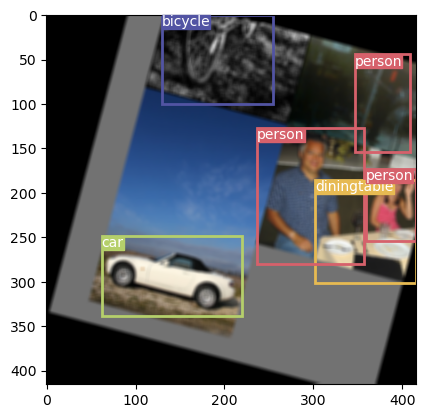

In [48]:
plot_image(image.permute(1, 2, 0), bboxes)